## Study effect of less training data

In [1]:
nlines = 10 #How many lines of data to use for training?
nltest = 60 #How many lines for the test set?

In [2]:
## Choose GPUs and CPUs

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"


import tensorflow as tf
import keras
from keras import backend as K
from keras.datasets import mnist

from keras.layers import Conv2D, MaxPool2D
from keras.models import Sequential
from keras.utils import to_categorical, multi_gpu_model, plot_model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout
from keras.models import Model

GPU=True
CPU=False
num_cores = 32

if GPU:
    num_GPU = len(os.environ["CUDA_VISIBLE_DEVICES"].split(','))
    num_CPU = 4
if CPU:
    num_CPU = 4
    num_GPU = 0

config = tf.ConfigProto(
                       )
config.gpu_options.allow_growth=True 
session = tf.Session(config=config)
K.set_session(session)



Using TensorFlow backend.


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import glob
from tqdm import tqdm_notebook as tqdm
# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

import keras_helper
from keras_helper import *
from skimage.transform import resize

In [4]:
h,w=64,64
nepochs=75
wt_path = 'wts5'
batch_size = 32

if (not os.path.isdir(wt_path)):
    os.mkdir(wt_path)

### Read training data

In [5]:
data_diffr = np.load('data/20191008_39_diff.npz')['arr_0']

In [6]:
print(data_diffr.shape)
#plt.matshow(np.log10(data_diffr[0,0]))

data_diffr_red = np.zeros((data_diffr.shape[0],data_diffr.shape[1],64,64), float)
for i in tqdm(range(data_diffr.shape[0])):
    for j in range(data_diffr.shape[1]):
        data_diffr_red[i,j] = resize(data_diffr[i,j,32:-32,32:-32],(64,64),preserve_range=True, anti_aliasing=True)
        data_diffr_red[i,j] = np.where(data_diffr_red[i,j]<3,0,data_diffr_red[i,j])


(161, 161, 256, 256)


In [7]:
#amp = np.load('../expt_data/s26_data/20191008_30_10nm_amp.npz')['arr_0']
#ph = np.load('../expt_data/s26_data/20191008_39_10nm.npz')['arr_0']
real_space = np.load('data/20191008_39_amp_pha_10nm_full.npy')
amp = np.abs(real_space)
ph = np.angle(real_space)
amp.shape

(161, 161, 64, 64)

W0615 21:05:20.024102 140129710683968 font_manager.py:1282] findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


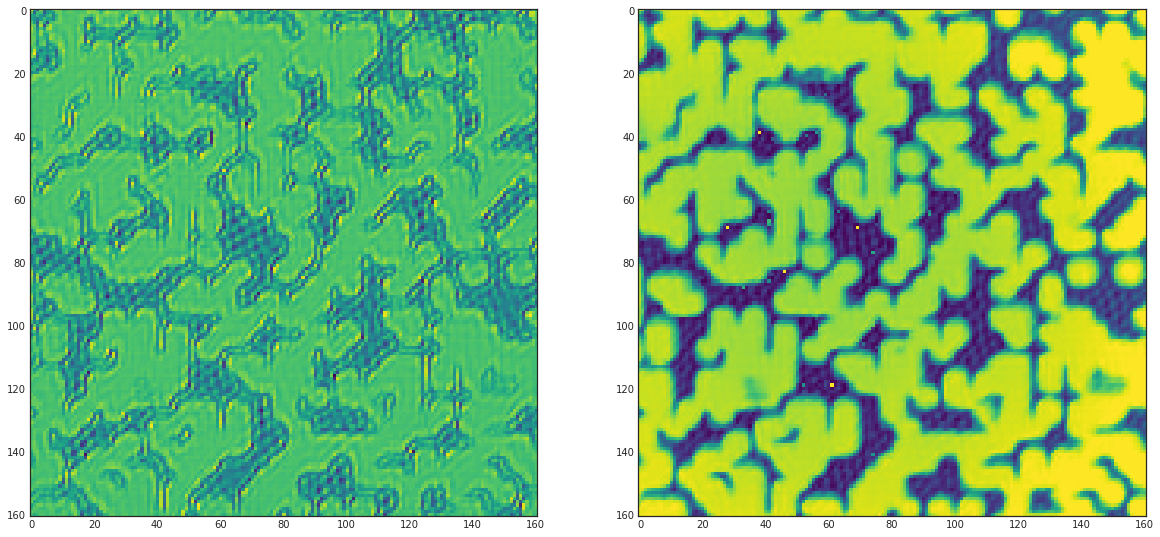

In [8]:
fig,ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(amp[:,:,32,32])
ax[1].imshow(ph[:,:,32,32], vmin=-1.5, vmax=1.5)

### Split data and then shuffle

In [9]:
tst_strt = amp.shape[0]-nltest #Where to index from
print(tst_strt)

101


In [10]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


X_train = data_diffr_red[:nlines,:].reshape(-1,h,w)[:,:,:,np.newaxis]
X_test = data_diffr_red[tst_strt:,tst_strt:].reshape(-1,h,w)[:,:,:,np.newaxis]
Y_I_train = amp[:nlines,:].reshape(-1,h,w)[:,:,:,np.newaxis]
Y_I_test = amp[tst_strt:,tst_strt:].reshape(-1,h,w)[:,:,:,np.newaxis]
Y_phi_train = ph[:nlines,:].reshape(-1,h,w)[:,:,:,np.newaxis]
Y_phi_test = ph[tst_strt:,tst_strt:].reshape(-1,h,w)[:,:,:,np.newaxis]

ntrain = X_train.shape[0]*X_train.shape[1]
ntest = X_test.shape[0]*X_test.shape[1]

print(X_train.shape, X_test.shape)

X_train, Y_I_train, Y_phi_train = shuffle(X_train, Y_I_train, Y_phi_train, random_state=0)

(1610, 64, 64, 1) (3600, 64, 64, 1)


# Autoencoder-structure predictor

In [11]:

K.clear_session()
np.random.seed(123)
model=Sequential()

files=glob.glob('%s/*' %wt_path)
for file in files:
    os.remove(file)


input_img = Input(shape=(h, w, 1)) 

x = Conv_Pool_block(input_img,32,w1=3,w2=3,p1=2,p2=2, padding='same', data_format='channels_last')
x = Conv_Pool_block(x,64,w1=3,w2=3,p1=2,p2=2, padding='same', data_format='channels_last')
x = Conv_Pool_block(x,128,w1=3,w2=3,p1=2,p2=2, padding='same', data_format='channels_last')
#Activations are all ReLu

encoded=x

#Decoding arm 1
x1=Conv_Up_block(encoded,128,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')
x1=Conv_Up_block(x1,64,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')
x1=Conv_Up_block(x1,32,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')

decoded1 = Conv2D(1, (3, 3), padding='same')(x1)


#Decoding arm 2
x2=Conv_Up_block(encoded,128,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')
x2=Conv_Up_block(x2,64,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')
x2=Conv_Up_block(x2,32,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')

decoded2 = Conv2D(1, (3, 3), padding='same')(x2)

#Put together
autoencoder = Model(input_img, [decoded1, decoded2])
parallel_model = ModelMGPU(autoencoder, gpus=num_GPU)
parallel_model.compile(optimizer='adam', loss='mean_absolute_error')

print (autoencoder.summary())
#plot_model(autoencoder, to_file='paper_data/str_model.png')


W0615 21:05:20.945630 140129710683968 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0615 21:05:20.947160 140129710683968 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0615 21:05:20.952667 140129710683968 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0615 21:05:20.983655 140129710683968 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W061

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 32, 32, 32)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [12]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.0001, verbose=1)

checkpoints=keras.callbacks.ModelCheckpoint('%s/weights.{epoch:02d}.hdf5' %wt_path, 
                                            monitor='val_loss', verbose=1, save_best_only=True, 
                                            save_weights_only=False, mode='auto', period=1)

history=parallel_model.fit(X_train, [Y_I_train, Y_phi_train], shuffle=True, batch_size=batch_size, verbose=1, 
                           epochs=nepochs, validation_split = 0.05, callbacks=[checkpoints, reduce_lr])

Train on 1529 samples, validate on 81 samples
Epoch 1/75
1529/1529 [==============================] - 5s 3ms/step - loss: 1.5876 - conv2d_13_loss: 0.3368 - conv2d_20_loss: 1.2508 - val_loss: 0.5978 - val_conv2d_13_loss: 0.0137 - val_conv2d_20_loss: 0.5841

Epoch 00001: val_loss improved from inf to 0.59783, saving model to wts5/weights.01.hdf5
Epoch 2/75
1529/1529 [==============================] - 1s 784us/step - loss: 0.5837 - conv2d_13_loss: 0.0118 - conv2d_20_loss: 0.5719 - val_loss: 0.5643 - val_conv2d_13_loss: 0.0103 - val_conv2d_20_loss: 0.5541

Epoch 00002: val_loss improved from 0.59783 to 0.56435, saving model to wts5/weights.02.hdf5
Epoch 3/75
1529/1529 [==============================] - 1s 806us/step - loss: 0.5566 - conv2d_13_loss: 0.0099 - conv2d_20_loss: 0.5467 - val_loss: 0.5289 - val_conv2d_13_loss: 0.0092 - val_conv2d_20_loss: 0.5197

Epoch 00003: val_loss improved from 0.56435 to 0.52891, saving model to wts5/weights.03.hdf5
Epoch 4/75
1529/1529 [====================

1529/1529 [==============================] - 1s 778us/step - loss: 0.1352 - conv2d_13_loss: 0.0062 - conv2d_20_loss: 0.1290 - val_loss: 0.1660 - val_conv2d_13_loss: 0.0062 - val_conv2d_20_loss: 0.1597

Epoch 00028: val_loss improved from 0.17085 to 0.16595, saving model to wts5/weights.28.hdf5
Epoch 29/75
1529/1529 [==============================] - 1s 797us/step - loss: 0.1285 - conv2d_13_loss: 0.0062 - conv2d_20_loss: 0.1223 - val_loss: 0.1609 - val_conv2d_13_loss: 0.0062 - val_conv2d_20_loss: 0.1547

Epoch 00029: val_loss improved from 0.16595 to 0.16095, saving model to wts5/weights.29.hdf5
Epoch 30/75
1529/1529 [==============================] - 1s 760us/step - loss: 0.1251 - conv2d_13_loss: 0.0061 - conv2d_20_loss: 0.1190 - val_loss: 0.1674 - val_conv2d_13_loss: 0.0062 - val_conv2d_20_loss: 0.1612

Epoch 00030: val_loss did not improve from 0.16095
Epoch 31/75
1529/1529 [==============================] - 1s 753us/step - loss: 0.1257 - conv2d_13_loss: 0.0061 - conv2d_20_loss: 0.11


Epoch 00055: val_loss improved from 0.12969 to 0.12883, saving model to wts5/weights.55.hdf5
Epoch 56/75
1529/1529 [==============================] - 1s 744us/step - loss: 0.0816 - conv2d_13_loss: 0.0056 - conv2d_20_loss: 0.0760 - val_loss: 0.1278 - val_conv2d_13_loss: 0.0058 - val_conv2d_20_loss: 0.1221

Epoch 00056: val_loss improved from 0.12883 to 0.12784, saving model to wts5/weights.56.hdf5
Epoch 57/75
1529/1529 [==============================] - 1s 736us/step - loss: 0.0806 - conv2d_13_loss: 0.0056 - conv2d_20_loss: 0.0750 - val_loss: 0.1275 - val_conv2d_13_loss: 0.0058 - val_conv2d_20_loss: 0.1218

Epoch 00057: val_loss improved from 0.12784 to 0.12752, saving model to wts5/weights.57.hdf5
Epoch 58/75
1529/1529 [==============================] - 1s 765us/step - loss: 0.0796 - conv2d_13_loss: 0.0056 - conv2d_20_loss: 0.0741 - val_loss: 0.1274 - val_conv2d_13_loss: 0.0057 - val_conv2d_20_loss: 0.1217

Epoch 00058: val_loss improved from 0.12752 to 0.12743, saving model to wts5/w

W0615 21:07:00.422184 140129710683968 font_manager.py:1282] findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


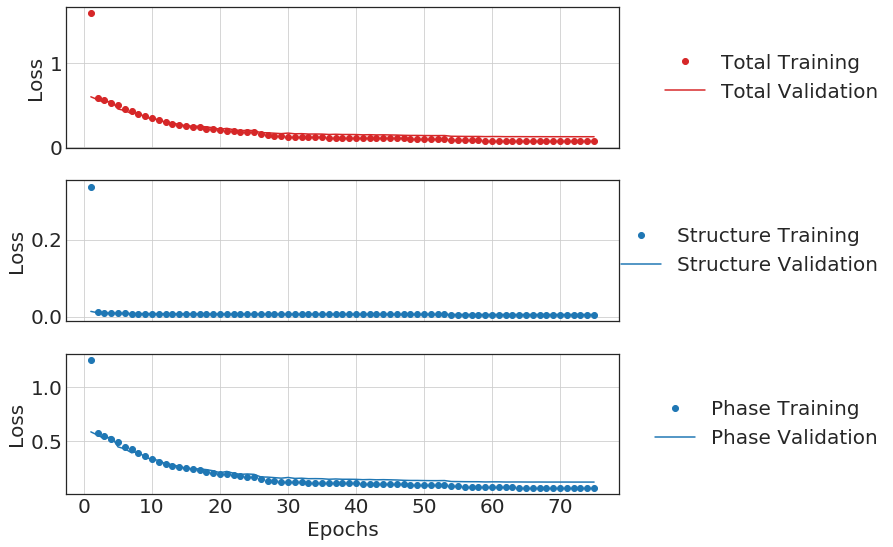

In [13]:
hist=history
epochs=np.asarray(history.epoch)+1

%matplotlib inline
import matplotlib
plt.style.use('seaborn-white')
matplotlib.rc('font',family='Times New Roman')
matplotlib.rcParams['font.size'] = 20

f, axarr = plt.subplots(3, sharex=True, figsize=(12, 8))

axarr[0].set(ylabel='Loss')
axarr[0].plot(epochs,hist.history['loss'], 'C3o', label='Total Training')
axarr[0].plot(epochs,hist.history['val_loss'], 'C3-', label='Total Validation')
axarr[0].grid()
axarr[0].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))

axarr[1].set(ylabel='Loss')
axarr[1].plot(epochs,hist.history['conv2d_13_loss'], 'C0o', label='Structure Training')
axarr[1].plot(epochs,hist.history['val_conv2d_13_loss'], 'C0-', label='Structure Validation')
axarr[1].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.xlabel('Epochs')
plt.tight_layout()
axarr[1].grid()


axarr[2].set(ylabel='Loss')
axarr[2].plot(epochs,hist.history['conv2d_20_loss'], 'C0o', label='Phase Training')
axarr[2].plot(epochs,hist.history['val_conv2d_20_loss'], 'C0-', label='Phase Validation')
axarr[2].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.tight_layout()
axarr[2].grid()


In [14]:
#np.save('paper_data/str_history', history.history)

### Save the model with the lowest validation error for future reference

In [15]:
val_losses=hist.history['val_loss']
min_epoch=np.argmin(val_losses)+1
print (min_epoch)
np.save('%s/min_epoch' %(wt_path), min_epoch)

72


In [16]:
min_epoch = np.load('%s/min_epoch.npy' %wt_path)
from keras.models import Model, load_model
model=load_model('%s/weights.%02d.hdf5' %(wt_path,min_epoch))

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


### Make predictions using the sparse-sampled test data

In [17]:
preds_intens=(model.predict(X_test))
print (preds_intens[0].shape)

(3600, 64, 64, 1)


## Stitch NN predictions 

In [18]:
tst_side = nltest
tst_side
point_size = 3
overlap = 4*point_size

In [19]:

composite_amp = np.zeros((tst_side*point_size+overlap,tst_side*point_size+overlap),float)
ctr = np.zeros_like(composite_amp)
data_reshaped = preds_intens[0].reshape(tst_side,tst_side,64,64)[:,:,32-int(overlap/2):32+int(overlap/2),
                                                     32-int(overlap/2):32+int(overlap/2)]

for i in range(tst_side):
    for j in range(tst_side):
        composite_amp[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] += data_reshaped[i,j]
        ctr[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] +=1


In [20]:

composite_phase = np.zeros((tst_side*point_size+overlap,tst_side*point_size+overlap),float)
ctr = np.zeros_like(composite_phase)
data_reshaped = preds_intens[1].reshape(tst_side,tst_side,64,64)[:,:,32-int(overlap/2):32+int(overlap/2),
                                                     32-int(overlap/2):32+int(overlap/2)]

for i in range(tst_side):
    for j in range(tst_side):
        composite_phase[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] += data_reshaped[i,j]
        ctr[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] +=1


In [21]:
stitched_phase = composite_phase[int(overlap/2):-int(overlap/2), int(overlap/2):-int(overlap/2)]/ctr[int(overlap/2)
                                                                    :-int(overlap/2), int(overlap/2):-int(overlap/2)]

stitched_amp = composite_amp[int(overlap/2):-int(overlap/2), int(overlap/2):-int(overlap/2)]/ctr[int(overlap/2)
                                                                    :-int(overlap/2), int(overlap/2):-int(overlap/2)]

stitched_amp_down = resize(stitched_amp, (60,60), preserve_range=True, anti_aliasing=True)
stitched_phase_down = resize(stitched_phase, (60,60), preserve_range=True, anti_aliasing=True)

## Plot the ePIE reconstruction, the PtychoNN prediction and the difference between the two

In [22]:
amp = Y_I_test.reshape(nltest,nltest,64,64)
ph = Y_phi_test.reshape(nltest,nltest,64,64)

(-0.5, 59.5, 59.5, -0.5)

W0615 21:07:03.823880 140129710683968 font_manager.py:1282] findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


<Figure size 432x288 with 0 Axes>

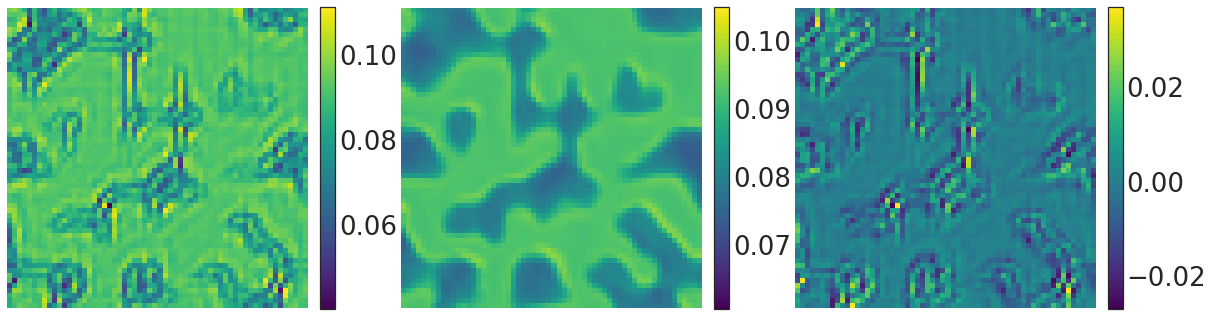

In [23]:
plt.rcParams.update({'font.size': 26})
plt.viridis()
fig, ax = plt.subplots(1,3,figsize=(20,12))

im=ax[0].imshow(amp[:,:,32,32])#,vmin=minc, vmax=maxc)
ax[0].axis('off')
cb = plt.colorbar(im,ax=ax[0], fraction=0.046, pad=0.04)

im=ax[1].imshow(stitched_amp_down,vmin=0.0605,vmax=0.105)
plt.colorbar(im,ax=ax[1], fraction=0.046, pad=0.04)
ax[1].axis('off')

im=ax[2].imshow(stitched_amp_down-amp[:,:,32,32], vmin=-0.027,vmax=0.037)
plt.colorbar(im,ax=ax[2], fraction=0.046, pad=0.04)
ax[2].axis('off')

(-0.5, 59.5, 59.5, -0.5)

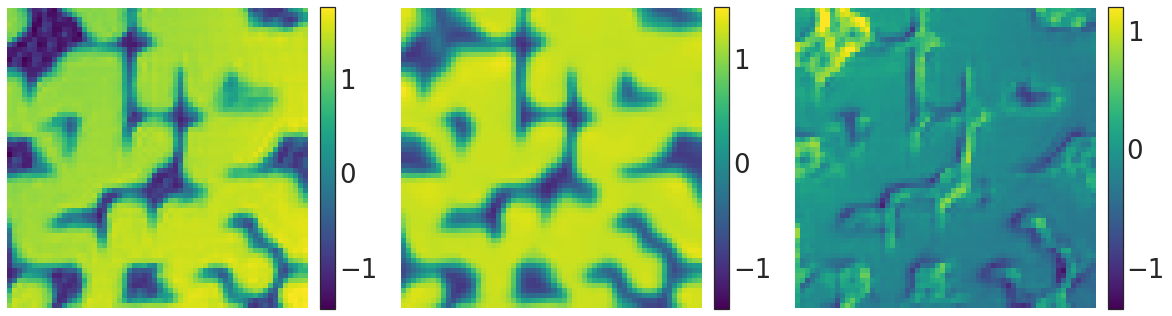

In [24]:
fig, ax = plt.subplots(1,3,figsize=(20,10))

im=ax[0].imshow(ph[:,:,32,32])#,vmin=minc, vmax=maxc)
plt.colorbar(im,ax=ax[0], fraction=0.046, pad=0.04)
ax[0].axis('off')

im=ax[1].imshow(stitched_phase_down,vmin=-1.4, vmax=1.5)
plt.colorbar(im,ax=ax[1], fraction=0.046, pad=0.04)
ax[1].axis('off')

im=ax[2].imshow(stitched_phase_down-ph[:,:,32,32],vmin=-1.35, vmax=1.2)
plt.colorbar(im,ax=ax[2], fraction=0.046, pad=0.04)
ax[2].axis('off')

### Quantify error between phase retrieval and PtychoNN

In [25]:
from sklearn.metrics import mean_squared_error as mse
print ("MSE in amplitude: ", mse(stitched_amp_down, amp[:,:,32,32]))
print ("MSE in phase: ", mse(stitched_phase_down, ph[:,:,32,32]))

MSE in amplitude:  5.150312583645702e-05
MSE in phase:  0.10273966426298471
